In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41479")
client

<Client: 'tcp://127.0.0.1:41479' processes=2 threads=2, memory=5.86 GiB>

In [2]:
import xarray as xr
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/mnt/meom/workdir/uchidat/Stage/LeGarrec'

# Read the data file

In [4]:
dst = xr.open_zarr(op.join(ddir,'SST_15N-50N.zarr'))
dst

<xarray.Dataset>
Dimensions:  (YC: 423, XC: 1000, nmemb: 48, time: 36, XG: 1000, YG: 423)
Coordinates: (12/29)
    Depth    (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    PHrefC   float32 ...
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * XG       (XG) float32 262.0 262.0 262.1 262.2 ... 347.7 347.8 347.8 347.9
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
  * YG       (YG) float32 14.96 15.04 15.13 15.21 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (YC, XG) int8 dask.array<chunksize=(212, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rhoRef   float32 ...
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days
Dimensions without coordinates: nmemb
Data variables:
    THETA    (nmemb, time, YC, XC) float32 dask.array<chunksize=(6, 5, 106, 250), meta=np.ndarray>

The time dimension has 36 slices. They consist of 5-day averaged simulation outputs for the winter and summer months of 1967 (i.e. Jan., Feb., Mar. and Jul., Aug., Sep. respectively).

# Compute the ensemble mean and residual from it

In [5]:
Tb = dst.THETA.mean('nmemb',skipna=True)   # Mean over the ensemble dimension
Tp = dst.THETA - Tb                        # Residual from the ensemble mean
print(Tb, Tp)

<xarray.DataArray 'THETA' (time: 36, YC: 423, XC: 1000)>
dask.array<mean_agg-aggregate, shape=(36, 423, 1000), dtype=float32, chunksize=(5, 106, 250), chunktype=numpy.ndarray>
Coordinates: (12/15)
    Depth    (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    PHrefC   float32 ...
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
    Z        float32 ...
    Zl       float32 ...
    ...       ...
    iter     (time) int64 dask.array<chunksize=(36,), meta=np.ndarray>
    maskC    (YC, XC) int8 dask.array<chunksize=(212, 1000), meta=np.ndarray>
    maskInC  (YC, XC) int8 dask.array<chunksize=(212, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(212, 500), meta=np.ndarray>
    rhoRef   float32 ...
  * time     (time) timedelta64[ns] 3290 days 3295 days ... 3550 days 3555 days <xarray.DataArray 'THETA' (nmemb: 48, time: 36, YC: 423, XC: 100

# Try plotting some stuff

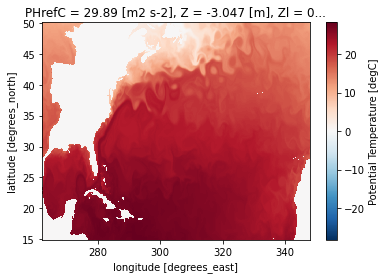

In [13]:
dst.THETA.isel(nmemb=0,time=0).plot(rasterized=True)

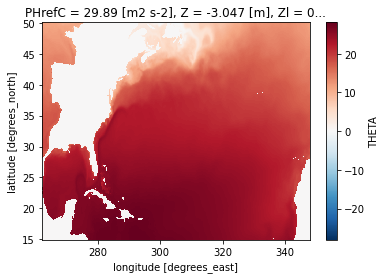

In [14]:
Tb.isel(time=0).plot(rasterized=True)

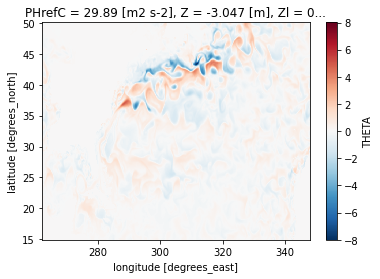

In [ ]:
Tp.isel(nmemb=0,time=0).plot(rasterized=True)

The ensemble mean field is much smoother than the residual. What does the mean and eddy part represent (statistically and physically)?

## Let's try masking out the land

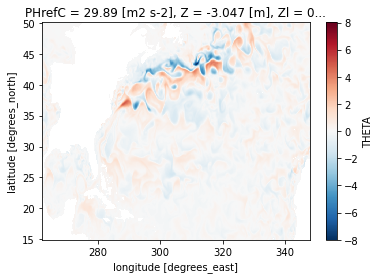

In [16]:
Tp.isel(nmemb=0,time=0).where(dst.maskInC!=0.).plot(rasterized=True)

## Can we zoom into the Gulf Stream?

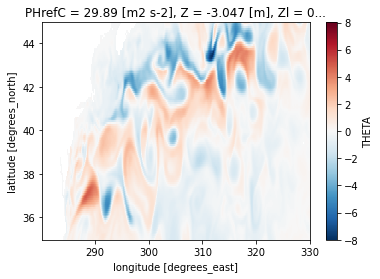

In [17]:
Tp.isel(nmemb=0,time=0).where(dst.maskInC!=0.).sel(YC=slice(35,45),XC=slice(280,330)).plot(rasterized=True)

## More flexibility in the plot

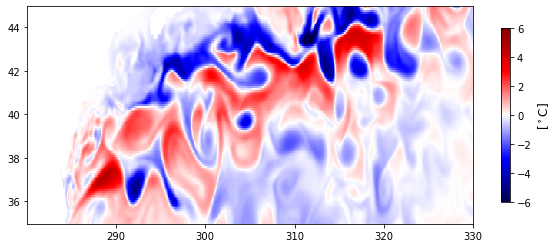

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
im = ax.pcolormesh(Tp.XC.sel(XC=slice(280,330)), Tp.YC.sel(YC=slice(35,45)), 
                   Tp.isel(nmemb=0,time=0).where(dst.maskInC!=0.).sel(YC=slice(35,45),XC=slice(280,330)),
                   cmap='seismic', vmax=6, vmin=-6
                  )
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"[$^\circ$C]", fontsize=12)

Python has really good documentation (e.g. [Matplotlib](https://matplotlib.org/stable/)) and Googling will be your new best friend. I often Google myself.